In [11]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

In [12]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


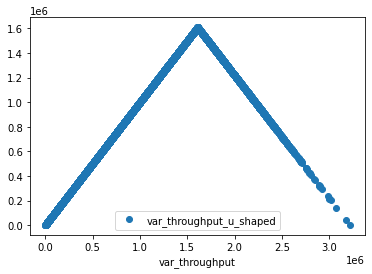

In [3]:
######################################
## Weighted Onehot Encoding options ##
######################################

##############
# Throughput #
##############
# TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# (For TP3 & TP4, k=1 results in V-shaped variance, and as k>1 increases, sides will curve into U-shaped variance)

############
# Worktime #
############
# WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

################
# PC agreement #
################
# PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)

#####################
# Input text length #
#####################
# TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

###################
# Special Options #
###################
# SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP2: weighted by average of WT1 and WT2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_UNI: weighted by 1 uniformly distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

# Select 1 option from each of the few variants above, e.g. TP2, WT1, PC3, TL1, SP3, and input into function
# set_OHE_pipeline_options. If not selecting TP3 or TP4, input k (option_k) will be ignored. After
# editing the options, run the entire notebook for results accordingly.

# Edit option choices here
throughput_option = 'TP3'
worktime_option = 'WT2'
pc_agreement_option = 'PC2'
textlength_option = 'TL1'
special_option = 'SP1'
k_option_for_tp = 1

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [4]:
######################################
## Model Options ##
######################################
# options: lstm, cnn, lstm-attn

model_name = 'lstm-attn'
models_nn.MODEL_NAME = model_name

In [5]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [ ]:
###################################
# pipeline-onehot Function blocks #
###################################

def sss_train_test_split(dataframe, class_name, n_splits, test_size, random_state):
    y = dataframe[class_name].copy()
    X = dataframe.drop([class_name], axis=1)
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    splits_generator = sss.split(X, y)

    for train_idx, test_idx in splits_generator:
        indices_train = train_idx
        indices_test = test_idx

    train = df.take(indices_train)
    test = df.take(indices_test)
    
    return indices_train, indices_test, train, test

def generate_class_weights(train_data, annotation_name):
    # Check if first class label is numeric or alphabetic
    if type(train_data[annotation_name].to_list()[0]) != int or type(train_data[annotation_name].to_list()[0]) != float:
        ## Convert to int type
        tmp_y_train[annotation_name] = train_data[annotation_name].apply(lambda x : 1 if x == "Straightforward" else 0)
        y_train = tmp_y_train[annotation_name].to_list()
    else:
        y_train = train_data[annotation_name].tolist()
    
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    return y_train, class_weight_dict

def label_preprocessing(y_data, label_encoder):
    out = label_encoder.fit_transform(y_data).reshape(-1,1)
    return out

def individual_model(x_train_data, y_train_data, x_val_data, y_val_data, class_weight_dict, indiv_batch_size, indiv_epochs):
    model = models_nn.create_nn_model()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = RMSprop(),
                  metrics = ['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
    model.fit(x_train_data,y_train_data,
              batch_size=indiv_batch_size,
              epochs=indiv_epochs,
              validation_data=(x_val_data, y_val_data), 
              callbacks=[models_nn.early_stop],
              class_weight=class_weight_dict)
    
    pred = model.predict(x_train_data)
    pred_test = model.predict(x_val_data)

    pred_test_round = pred_test.round()
    precision_recall_fscore_support(y_val_data, pred_test_round, average='macro')
    return pred, pred_test

# (HARD-CODED)
def generate_encodings(gamemove_pred, reasoning_pred, shareinfo_pred, rapport_pred):
    pred_df_arr_full = []
    pred_df_arr = []
    for i in range(0, len(gamemove_pred)):
        pred_obj_1 = {}
        pred_obj_1['gamemove'] = gamemove_pred[i][0]
        pred_obj_1['reasoning'] = reasoning_pred[i][0]
        pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
        pred_df_arr.append(pred_obj_1)

        pred_obj_2 = pred_obj_1.copy()
        pred_obj_2['rapport'] = rapport_pred[i][0]
        pred_df_arr_full.append(pred_obj_2)

    pred_df_full = pd.DataFrame(pred_df_arr_full)
    pred_df = pd.DataFrame(pred_df_arr)
    return pred_df_full, pred_df

In [68]:
df["Input.train_test_val"].to_list()[0]

'Train'

In [ ]:
####################################
# Arguments for current experiment #
####################################

# Metadata options
throughput_option = 'TP3'
worktime_option = 'WT2'
pc_agreement_option = 'PC2'
textlength_option = 'TL1'
special_option = 'SP1'
k_option_for_tp = 1
metadata_options_list = [throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp]

# Train_test_split SSS options
n_splits = 1
test_size = 0.2
random_state = 0

# Individual model options
model_name = 'lstm-attn'
indiv_batch_size = 128
indiv_epochs = 15

In [6]:
##################################################
# Main function for dataset sampling experiments #
##################################################

# Currently only supports annotations with 2 classes, i.e. binary

def dataset_sampling(dataframe, class_name, annotation_name_list, sampling_size_list, metadata_options_list, model_name):
    
    # Metadata settings
    df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(dataframe, *metadata_options_list)
    
    # Model settings (for individual annotation models)
    models_nn.MODEL_NAME = model_name
    
    # Full dataframe proportions
    full_size = dataframe.shape[0]
    full_counts = dataframe[class_name].value_counts()
    print("Full dataset proportions w.r.t. {}".format(class_name))
    print(full_counts)
    full_counts_dict = full_counts.to_dict()
    full_counts_list = list(full_counts_dict.values())
    
    ## class_proportions is a list of class proportions, first item corresponding to first class, etc
    class_proportions = []
    for each_class_counts in full_counts_list:
        class_proportions.append(each_class_counts / full_size)
    
    # Looping through sample_size_list
    for each_sample_size in sampling_size_list:
        print("#################################")
        print("Sample size: {}".format(each_sample_size))
        print("#################################")
        
        ## Counting number of datapoints per class proportionate to main dataset
        class_sizes = [round(each_sample_size * class_proportions[0])]
        class_sizes.append(each_sample_size - class_sizes[0])
        
        ## Creating sub dataframe
        s0 = dataframe.loc[dataframe[class_name] == [full_counts_dict.keys()][0]].sample(class_sizes[0])
        s1 = dataframe.loc[dataframe[class_name] == [full_counts_dict.keys()][1]].sample(class_sizes[1])
        sub_df = df.loc[s0.union(s1)]
        
        ## Train_test_split using SSS
        indices_train, indices_test, train, test = sss_train_test_split(dataframe, class_name, n_splits, test_size, random_state)
        
        ## Generate class weights dict and y_train data (HARD-CODED)
        y_train_deception, deception_class_weight_dict = generate_class_weights(train, "Input.deception_quadrant")
        y_train_rapport, rapport_class_weight_dict = generate_class_weights(train, 'Answer.3rapport.yes_label')
        y_train_share_information, share_info_class_weight_dict = generate_class_weights(train, 'Answer.4shareinformation.yes_label')
        y_train_reasoning, reasoning_class_weight_dict = generate_class_weights(train, 'Answer.2reasoning.yes_label')
        y_train_gamemove, gamemove_class_weight_dict = generate_class_weights(train, 'Answer.1gamemove.yes_label')
        print("Class weights")
        print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                          rapport_class_weight_dict,
                                                                                                          share_info_class_weight_dict,
                                                                                                          reasoning_class_weight_dict,
                                                                                                          gamemove_class_weight_dict))
        
        ## Train and test data preparation (HARD-CODED)
        X_train_col = train['Input.full_text']
        
        new_deception_test = test["Input.deception_quadrant"].copy()
        new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
        y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
        y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
        y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
        y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
        y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()
        X_test_col = test['Input.full_text']
        
        le = LabelEncoder()

        y_train_deception = label_preprocessing(y_train_deception, le)
        y_train_rapport = label_preprocessing(y_train_rapport, le)
        y_train_share_information = label_preprocessing(y_train_share_information, le)
        y_train_reasoning = label_preprocessing(y_train_reasoning, le)
        y_train_gamemove = label_preprocessing(y_train_gamemove, le)
        
        y_test_deception = label_preprocessing(y_test_deception, le)
        y_test_rapport = label_preprocessing(y_test_rapport, le)
        y_test_share_information = label_preprocessing(y_test_share_information, le)
        y_test_reasoning = label_preprocessing(y_test_reasoning, le)
        y_test_gamemove = label_preprocessing(y_test_gamemove, le)
        
        ## Tokenizer settings
        max_words = 1000
        max_len = 220

        tok = Tokenizer(num_words=max_words)

        tok.fit_on_texts(X_train_col)
        X_train_sequences = tok.texts_to_sequences(X_train_col)
        X_train = pad_sequences(X_train_sequences, maxlen=max_len)

        X_test_sequences = tok.texts_to_sequences(X_test_col)
        X_test = pad_sequences(X_test_sequences, maxlen=max_len)
        
        ## Individual Models
        ### Deception pred and pred_test not needed
        _, _ = individual_model(X_train, y_train_deception, X_test, y_test_deception, deception_class_weight_dict, indiv_batch_size, indiv_epochs)
        rapport_pred, rapport_pred_test = individual_model(X_train, y_train_rapport, X_test, y_test_rapport, rapport_class_weight_dict, indiv_batch_size, indiv_epochs)
        shareinfo_pred, shareinfo_pred_test = individual_model(X_train, y_train_share_information, X_test, y_test_share_information, share_info_class_weight_dict, indiv_batch_size, indiv_epochs)
        reasoning_pred, reasoning_pred_test = individual_model(X_train, y_train_reasoning, X_test, y_test_reasoning, reasoning_class_weight_dict, indiv_batch_size, indiv_epochs)
        gamemove_pred, gamemove_pred_test = individual_model(X_train, y_train_gamemove, X_test, y_test_gamemove, gamemove_class_weight_dict, indiv_batch_size, indiv_epochs)
        
        ## Generate one-hot encodings
        pred_df_full, pred_df = generate_encodings(gamemove_pred, reasoning_pred, shareinfo_pred, rapport_pred)
        pred_test_df_full, pred_test_df = generate_encodings(gamemove_pred_test, reasoning_pred_test, shareinfo_pred_test, rapport_pred_test)
    pass

In [38]:
test = df["Input.deception_quadrant"].value_counts().to_dict()

In [42]:
list(test.values())

[10808, 558]

In [34]:
class_1_test = test[0]/df.shape[0]

In [49]:
class_name = Input.deception_quadrant

AttributeError: 'function' object has no attribute 'deception_quadrant'

In [52]:
s0 = df.loc[df["Input.deception_quadrant"] == "Straightforward"].sample()
# s1 = df.label[df.label.eq(1)].sample(10000).index 

In [56]:
test = s0.sample(5)

In [57]:
test

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5136,7964,3SD15I2WD2U0OZ58UTTVH8QJ8CU639,Game11-germany-france,Validation,Game11-germany-france-84,939,Are you moving in with Piedmont or Tyrolia?,germany-Game11,Game11-germany-france-83,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2473,3840,3VQTAXTYN3LQT5ZM5464FX2BZQXUBY,Game1-england-germany,Train,Game1-england-germany-622,2449,I ran quite a few sandboxes in lieu of working...,germany-Game1,Game1-england-germany-621,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
10334,17356,3QHITW7OYO9TI2NDIHM3ALLGEN6AQE,Game4-england-germany,Test,Game4-england-germany-28,161,Just let me know of your intentions going forw...,germany-Game4,Game4-england-germany-27,Truth,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0
7204,11782,34HEO7RUG6UTU32DVWB3FBVLA96RAU,Game2-turkey-italy,Train,Game2-turkey-italy-158,1801,Its not just a matter of who has what its wher...,italy-Game2,Game2-turkey-italy-157,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7860,13148,3ZZAYRN1I6RVCM9694LGGLG8NB3OTZ,Game2-turkey-germany,Train,Game2-turkey-germany-83,1203,But in effect he will be giving up the channel...,turkey-Game2,Game2-turkey-germany-82,Truth,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
